In [ ]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
# Download images and choose a style image and a content image
content_path_1 = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_path_2   = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


In [ ]:
def load_img(path_to_img):  
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)  

  img = tf.image.convert_image_dtype(img, tf.float32)  
  img = tf.image.resize(img, (422, 512))
  img = img[tf.newaxis, :]
  
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

(1, 422, 512, 3)
(1, 422, 512, 3)


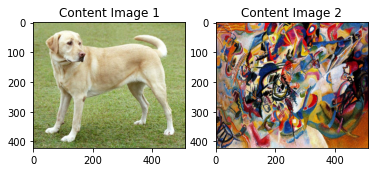

In [ ]:
content_image_1 = load_img(content_path_1)
content_image_2 = load_img(content_path_2)

print(content_image_1.shape)
print(content_image_2.shape)

plt.subplot(1, 2, 1)
imshow(content_image_1, 'Content Image 1')

plt.subplot(1, 2, 2)
imshow(content_image_2, 'Content Image 2')

In [ ]:
# Creates a vgg model that returns a list of intermediate output values
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], [outputs])
  return model

In [ ]:
# create the model:
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)

content_extractor = vgg_layers(content_layers)
content_2_outputs = content_extractor(content_image_2*255)

# Look at the statistics of each layer's output
for name, output in zip(content_layers, content_2_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block5_conv2
  shape:  (1, 26, 32, 512)
  min:  0.0
  max:  1707.5167
  mean:  21.519093



In [ ]:
class ContentModel(tf.keras.models.Model):
  def __init__(self, content_layers):
    super(ContentModel, self).__init__()
    self.vgg = vgg_layers(content_layers)
    self.content_layers = content_layers
    self.num_content_layers = len(content_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    content_outputs = self.vgg(preprocessed_input)

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    return content_dict

In [ ]:
extractor = ContentModel(content_layers)
content_1_targets = extractor(content_image_1)
content_2_targets = extractor(content_image_2)

In [ ]:
image = tf.Variable(tf.random.uniform(content_image_1.shape, minval=0, maxval=1))
print(image.shape)

(1, 422, 512, 3)


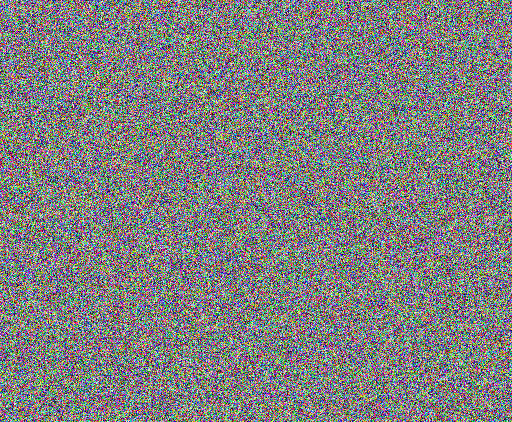

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

display.display(tensor_to_image(image))

fname = '/content/gdrive/My Drive/data/style_transfer/two_content_loss/at_%d.png' % 0
mpl.image.imsave(fname, image[0].numpy())

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

content_1_weight = 1e4
content_2_weight = 1e1

def content_loss(content_outputs):    
    content_1_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_1_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_1_loss *= content_1_weight / num_content_layers

    content_2_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_2_targets[name])**2) 
                           for name in content_outputs.keys()])
    content_2_loss *= content_2_weight / num_content_layers

    
    loss = content_2_loss + content_1_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

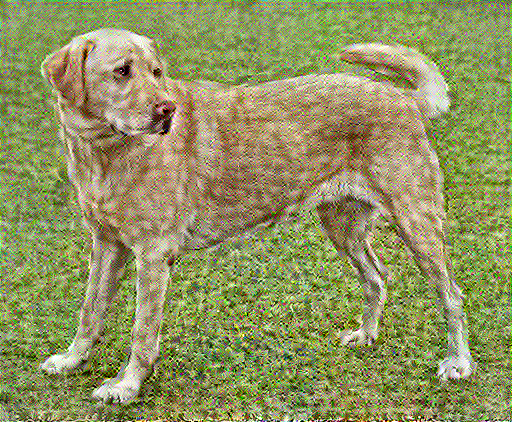

Train step: 12000
Total time: 332.7


In [ ]:
import time
start = time.time()

epochs = 40
steps_per_epoch = 300

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

  fname = '/content/gdrive/My Drive/data/style_transfer/two_content_loss/at_%d.png' % (n+1)
  mpl.image.imsave(fname, image[0].numpy())
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)